In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio

In [144]:
class GradientDescent:
    def __init__(self, scheduler, epochs, f_samples, x0):
        """
        :param lr: learning rate
        """
        self.scheduler = scheduler
        self.xk =  x0
        self.epochs = epochs
        self.f_samples = f_samples


    def train(self, f_gradient, f, gifname, get_step_params=lambda weights, f_gradient: None, diff_border=1e-3, plot=True):
        try:
            os.mkdir('gifs')
        except Exception:
            import shutil
            shutil.rmtree('gifs')
            os.mkdir('gifs')

        prev_min = self.xk
        trace = [self.xk]

        for i in range(self.epochs):
            step_params = get_step_params(self.xk, f_gradient)
            lr = self.scheduler.step(step_params)
            self.xk = self.xk - lr * f_gradient(self.xk)

            trace.append(self.xk)

            if np.linalg.norm(prev_min - self.xk) < diff_border:
                print(f"Early stopping: {i + 1}")
                break
            prev_min = self.xk

            if plot:
                plt.scatter(self.f_samples[0], self.f_samples[1], c='blue')
                plt.scatter(self.xk, f(self.xk), c='yellow')
                plt.title(f'Epoch: {i}')
                plt.xlabel('x')
                plt.ylabel('y')
                plt.savefig(f"gifs/{i}.jpg")
                plt.clf()

        if plot:
            with imageio.get_writer(f'{gifname}.gif', mode='I') as writer:
                for filename in sorted(os.listdir('gifs'), key=lambda x: int(x.split('.')[0])):
                    image = imageio.imread(f"gifs/{filename}")
                    writer.append_data(image)
        return self.xk, trace

In [72]:
f = lambda x: (x ** 3)/3 + (x ** 2)/2 - x - 1
f_grad = lambda weights: weights ** 2 + weights - 1

In [73]:
xs = np.linspace(-5, 5, 1000)
ys = np.vectorize(f)(xs)

In [74]:
class Scheduler:
    def __init__(self, start_lr):
        self.start_lr = start_lr

In [75]:
class ConstantScheduler(Scheduler):
    def __init__(self, start_lr):
        Scheduler.__init__(self, start_lr)

    def step(self, params):
        return self.start_lr

In [76]:
class StepScheduler(Scheduler):
    def __init__(self, start_lr, scheduler_step, gamma):
        assert scheduler_step > 0

        Scheduler.__init__(self, start_lr)
        self.cur_step = 0
        self.scheduler_step = scheduler_step
        self.gamma = gamma

    def step(self, params):
        self.cur_step += 1
        if self.cur_step % self.scheduler_step == 0:
            self.start_lr = self.gamma * self.start_lr
        return self.start_lr

## Пункт 1 - Constat LR GD

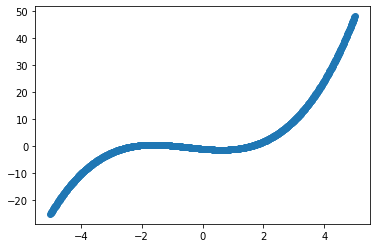

In [77]:
plt.scatter(xs, ys)

In [88]:
const_scheduler = ConstantScheduler(1)
const_trainer = GradientDescent(const_scheduler, 50, (xs, ys), x0=np.array([4]))
const_trainer.train(f_grad, f, 'new_const_lr=1')

<Figure size 432x288 with 0 Axes>

![SegmentLocal](new_const_lr=1.gif "segment")

# Пункт 2 - Step LR GD

In [101]:
step_scheduler = StepScheduler(1e-1, scheduler_step=15, gamma=0.1)
step_trainer = GradientDescent(step_scheduler, 50, (xs, ys), x0=np.array([4]))
step_trainer.train(f_grad, f, 'new_step')

Early stopping: 30


<Figure size 432x288 with 0 Axes>

![SegmentLocal](new_step.gif "segment")

# Пункт 3 - Дихотомия

In [90]:
DEFAULT_EPS = 1e-3

In [117]:
def dichotomy(f, f_samples, gif_folder, gifname, eps=DEFAULT_EPS, plot=True):
    delta = eps / 3
    if gif_folder is not None:
        try:
            os.mkdir(gif_folder)
        except Exception:
            pass
    def step(old_interval, cnt=0):
        a, b = old_interval
        mid = (a + b) / 2

        if plot:
            plt.scatter(f_samples[0], f_samples[1], c='blue')
            plt.scatter(mid, f(mid), c='yellow')
            plt.title(f'Epoch: {cnt}')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.savefig(f"{gif_folder}/{cnt}.jpg")
            plt.clf()

            with imageio.get_writer(f'{gifname}.gif', mode='I') as writer:
                for filename in sorted(os.listdir(gif_folder), key=lambda x: int(x.split('.')[0])):
                    image = imageio.imread(f"{gif_folder}/{filename}")
                    writer.append_data(image)

        if b - a < eps:
            return mid

        x1, x2 = mid - delta, mid + delta
        fx1, fx2 = f(x1), f(x2)

        if fx1 < fx2:
            new_interval = (a, x2)
        elif fx1 > fx2:
            new_interval = (x1, b)
        else:
            new_interval = (x1, x2)

        return step(new_interval, cnt+1)

    return step

In [29]:
dichotomy_algo = dichotomy(f, (xs, ys), "dichotomy", "simple_dichotomy")

In [30]:
dichotomy_algo([-1000, 1000])

0.618099960287412

<Figure size 432x288 with 0 Axes>

![SegmentLocal](simple_dichotomy.gif "segment")



In [92]:
class DichotomyScheduler(Scheduler):
    def __init__(self, interval):
        Scheduler.__init__(self, interval)

        self.interval = interval

        #lambda lr : self.weights - lr * f_gradient(self.weights)
    def step(self, lr_func):
        algo = dichotomy(lr_func, None, None, None, eps=1e-6, plot=False)
        lr = algo(self.interval)
        return lr

In [102]:
dichotomy_scheduler = DichotomyScheduler([0, 1e-1])
dichotomy_trainer = GradientDescent(dichotomy_scheduler, 50, (xs, ys), x0=np.array([4]))
dichotomy_trainer.train(f_grad, f, 'dichotomy_gd', get_step_params=lambda weights, f_gradient: lambda lr : f(weights - lr * f_gradient(weights)))

Early stopping: 32


<Figure size 432x288 with 0 Axes>

![SegmentLocal](dichotomy_gd.gif "segment")

## 5

In [109]:
f_multi = lambda xs: 5 * (xs[1] - xs[0]) ** 2 + (1 - xs[0]) ** 2
f_multi_grad = lambda xs: np.array([-10 * (xs[1] - xs[0]) + 2 * xs[0] - 2,  10 * (xs[1] - xs[0])])

In [355]:
from matplotlib.colors import ListedColormap


def plot_graph(f, trace):
    fig, ax = plt.subplots()

    x, y = np.mgrid[-10:10:1000j, -10:10:1000j]
    z = f([x, y])

    levels = [x ** 3 for x in range(8)]
    r = np.linspace(240, 166, 256) / 255.
    g = np.linspace(244, 188, 256) / 255.
    b = np.linspace(246, 203, 256) / 255.
    cmap = ListedColormap(np.vstack((r, g, b)).T)

    ax.contourf(x, y, z, levels = levels, cmap = cmap)
    cs = ax.contour(x, y, z, levels = levels)
    ax.clabel(cs, colors = "#2618B1")

    ax.plot(trace[:, 0], trace[:, 1], '-oy', linewidth=1, ms=1.5)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid()

    fig.set_figwidth(10)
    fig.set_figheight(12)

    plt.show()

In [327]:
step_scheduler = StepScheduler(9e-2, scheduler_step=50, gamma=0.5)
multi_step_trainer = GradientDescent(step_scheduler, 100, (xs, ys), x0=np.array([4, 4]))
minimum, trace = multi_step_trainer.train(f_multi_grad, f_multi, 'dichotomy_gd_multi',
                        get_step_params=lambda weights, f_gradient: lambda lr : f(weights - lr * f_gradient(weights)),
                        plot=False
                        )

Early stopping: 69


Min: [1.01486007 1.01642019]
(1000, 1000)


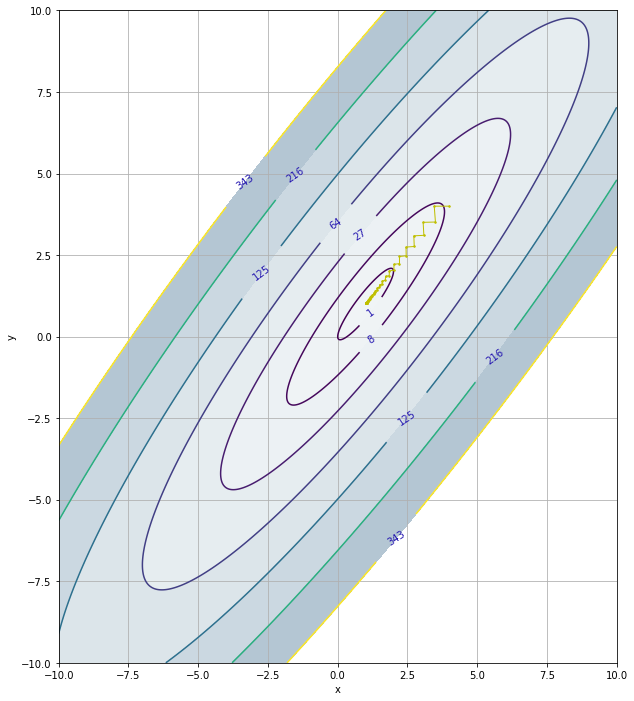

In [328]:
print('Min:', minimum)
plot_graph(f_multi, np.array(trace))

In [181]:
f_multi_2 = lambda xs: -(((xs[0] ** 2)/4 + (xs[1] ** 2)/4) ** (1 / 2) - ((xs[0] ** 4)/4 + (xs[1] ** 4)/4) ** (1 / 2))
f_multi_grad_2 = lambda xs: np.array([
    (xs[0] ** 3) / ((xs[0] ** 4 + xs[1] **4) ** (1 / 2)) - xs[0] / (2 * (xs[0] ** 2 + xs[1] ** 2) ** (1 / 2)),
    (xs[1] ** 3) / ((xs[0] ** 4 + xs[1] **4) ** (1 / 2)) - xs[1] / (2 * (xs[0] ** 2 + xs[1] ** 2) ** (1 / 2))
])

In [205]:
step_scheduler = StepScheduler(5e-1, scheduler_step=50, gamma=0.5)
multi_step_trainer = GradientDescent(step_scheduler, 100, (xs, ys), x0=np.array([5, 10]))
minimum, trace = multi_step_trainer.train(f_multi_grad_2, f_multi_2, 'dichotomy_gd_multi',
                        get_step_params=lambda weights, f_gradient: lambda lr : f(weights - lr * f_gradient(weights)),
                        plot=False
                        )

Early stopping: 20


Min: [0.50111496 0.50111496]


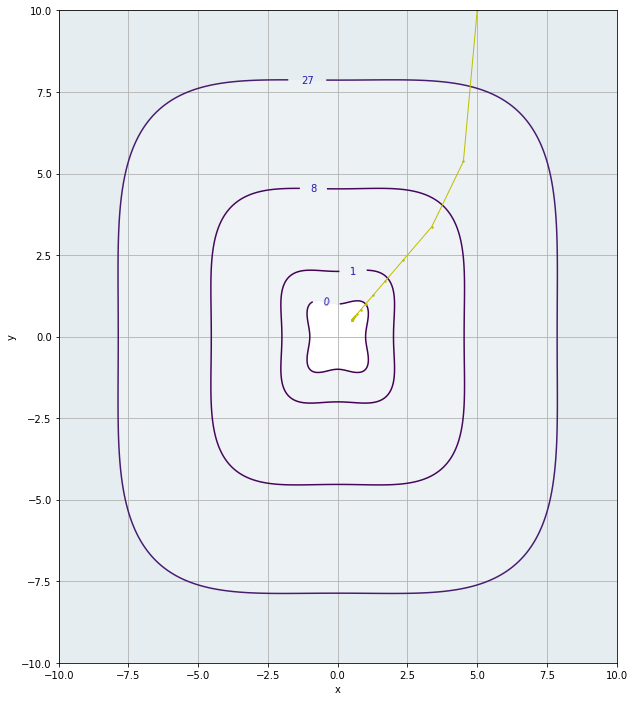

In [206]:
print('Min:', minimum)
plot_graph(f_multi_2, np.array(trace))

In [338]:
def generate_matrix(n, cond_number):
    d = np.sort(np.random.uniform(1, cond_number, n))[::-1]
    d[0], d[-1] = cond_number, 1.
    S = np.diag(d)
    U, _ = np.linalg.qr(np.random.rand(n, n))
    return U @ S @ U.T

def generate_func(n, cond_number):
    A = generate_matrix(n, cond_number)
    assert np.allclose(cond_number, np.linalg.cond(A))
    assert np.allclose(A, A.T)

    def f(args):
        x = np.array(args)
        return x @ A @ x.T

    def grad(args):
        x = np.array(args)
        return 2 * A @ x.T

    return f, grad

In [339]:
f_rand, f_rand_gradient =  generate_func(2, 10)

In [351]:
step_scheduler = StepScheduler(1e-2, scheduler_step=25, gamma=0.1)
multi_step_trainer = GradientDescent(step_scheduler, 100, (xs, ys), x0=np.array([5, 10]))
minimum, trace = multi_step_trainer.train(f_rand_gradient, f_rand, 'dichotomy_gd_multi',
                        get_step_params=lambda weights, f_gradient: lambda lr : f(weights - lr * f_gradient(weights)),
                        plot=False
                        )

Early stopping: 50


Min: [-1.78053609  2.74354886]


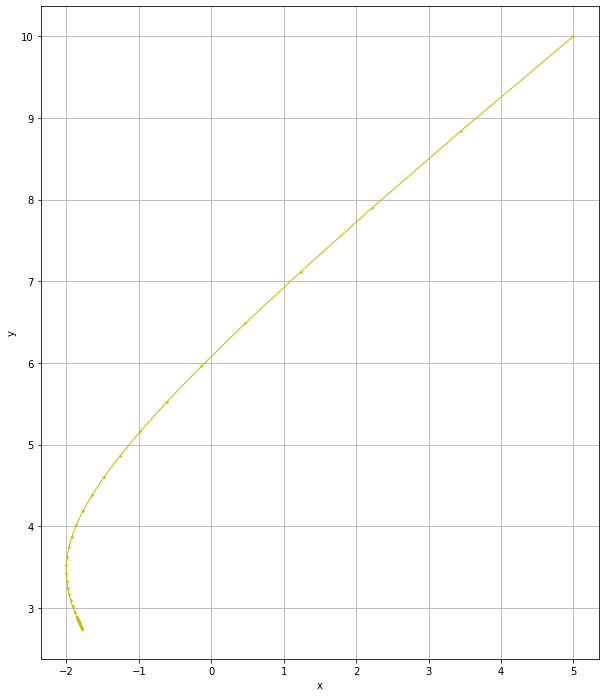

In [356]:
print('Min:', minimum)
plot_graph(f_rand, np.array(trace))